In [ ]:
! pip install plotly
! pip install folium
! pip install fuzzywuzzy
! pip install python-Levenshtein
! pip install pycountry-convert
! pip install streamlit-folium



In [2]:
# import pandas for structuring the data
import pandas as pd

# import numpy for numerical analysis
import numpy as np

# import libs for diagrams inline with the text
import matplotlib.pyplot as plt

import seaborn as sns

# other utilities
from sklearn import datasets, preprocessing, metrics

In [3]:
# for visualisation
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
import plotly.figure_factory as ff
import plotly.io as pio
from sklearn.model_selection import train_test_split
from sklearn import linear_model
from sklearn.linear_model import LinearRegression
import sklearn.metrics as sm

# for diagramming 
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
import seaborn as sns

# For serialization and deserialization of data from/to file
import pickle

In [4]:
import folium

In [5]:
# read the json file from your data folder into a data frame
#df = pd.read_csv(r'C:\Users\chz\Documents\BI Exercise\\BI Exam\global air pollution dataset.csv')
df = pd.read_csv(r'C:\Users\chz\Documents\BI Exercise\Datasæt\global_air_pollution_dataset.csv')
df2 = pd.read_csv(r"C:\Users\chz\Documents\BI Exercise\Datasæt\2017_-_Cities_Community_Wide_Emissions.csv")

In [6]:
df.count()

Country               23036
City                  23462
AQI Value             23463
AQI Category          23463
CO AQI Value          23463
CO AQI Category       23463
Ozone AQI Value       23463
Ozone AQI Category    23463
NO2 AQI Value         23463
NO2 AQI Category      23463
PM2.5 AQI Value       23463
PM2.5 AQI Category    23463
dtype: int64

In [7]:
df2.count()

Account number                                  229
Organization                                    229
City                                            229
Country                                         229
Region                                          229
C40                                              56
Access                                          229
Reporting year                                  229
Accounting year                                 229
Boundary                                        229
Protocol                                        229
Protocol column                                 151
Gases included                                  111
Total emissions (metric tonnes CO2e)            217
Scopes Included                                 229
Total Scope 1 Emissions (metric tonnes CO2e)    173
Total Scope 2 Emissions (metric tonnes CO2e)    172
Comment                                          79
Increase/Decrease from last year                209
Reason for i

In [30]:
# Define the correction mapping with the correct capitalization
correction_mapping = {
    "United States of America": "USA",
    "Viet Nam": "Vietnam",
    "Russian Federation": "Russia",
    "United Kingdom of Great Britain and Northern Ireland": "United Kingdom",
    "Bolivia (Plurinational State of)": "Bolivia",
    "Venezuela (Bolivarian Republic of)": "Venezuela",
    "Iran (Islamic Republic of)": "Iran",
    "Syrian Arab Republic": "Syria",
    "Republic of Korea": "South Korea",
    "Lao People's Democratic Republic": "Laos",
    # Add other corrections as needed
}

# Apply the correction mapping to df and df2 and overwrite the original 'Country' column
df['Country'] = df['Country'].replace(correction_mapping).str.strip()
df2['Country'] = df2['Country'].replace(correction_mapping).str.strip()

# Proceed with the merge using the corrected country names
df_merged = pd.merge(df, df2, on='Country', how='inner')

# Rename 'City_x' to 'City' and 'Country_x' to 'Country'
df_merged.rename(columns={'City_x': 'City',}, inplace=True)

# Drop the extra 'Country' column
df_merged.drop(columns=['City_y'], inplace=True)

# Rearrange the columns
column_order = ['Country', 'City', 'AQI Value', 'AQI Category', 'CO AQI Value', 'CO AQI Category', 'Ozone AQI Value', 'Ozone AQI Category', 'NO2 AQI Value', 'NO2 AQI Category', 'PM2.5 AQI Value', 'PM2.5 AQI Category', 'Account number', 'Organization', 'Region', 'C40', 'Access', 'Reporting year', 'Accounting year', 'Boundary', 'Protocol', 'Protocol column', 'Gases included', 'Total emissions (metric tonnes CO2e)', 'Total Scope 1 Emissions (metric tonnes CO2e)', 'Total Scope 2 Emissions (metric tonnes CO2e)', 'Comment', 'Increase/Decrease from last year', 'Reason for increase/decrease in emissions', 'Population', 'Population year', 'GDP', 'GDP Currency', 'GDP Year', 'GDP Source', 'Average annual temperature (in Celsius)​', '​Average altitude (m)', '​Land area (in square km)', 'City Location', 'Country Location']
# Reorder the DataFrame columns
df_merged = df_merged[column_order]


In [31]:
df_merged.count()

Country                                         288621
City                                            288620
AQI Value                                       288621
AQI Category                                    288621
CO AQI Value                                    288621
CO AQI Category                                 288621
Ozone AQI Value                                 288621
Ozone AQI Category                              288621
NO2 AQI Value                                   288621
NO2 AQI Category                                288621
PM2.5 AQI Value                                 288621
PM2.5 AQI Category                              288621
Account number                                  288621
Organization                                    288621
Region                                          288621
C40                                              50911
Access                                          288621
Reporting year                                  288621
Accounting

In [34]:
df_merged.sample(10)

,Country,City,AQI Value,AQI Category,CO AQI Value,CO AQI Category,Ozone AQI Value,Ozone AQI Category,NO2 AQI Value,NO2 AQI Category,...,Population year,GDP,GDP Currency,GDP Year,GDP Source,Average annual temperature (in Celsius)​,​Average altitude (m),​Land area (in square km),City Location,Country Location
46930,USA,Corvallis,44,Good,1,Good,15,Good,8,Good,...,2014,NaN,NaN,NaN,NaN,11.0,4.0,10.3,"(42.393449, -71.082647)","(37.09024, -95.712891)"
23953,Italy,Taurianova,57,Moderate,1,Good,56,Moderate,0,Good,...,2016,NaN,NaN,NaN,NaN,14.1,4.0,683.0,"(41.913028, 12.518037)","(41.87194, 12.56738)"
91386,USA,Collingswood,73,Moderate,1,Good,37,Good,5,Good,...,2016,1.558520e+12,USD US Dollar,2015.0,http://www.brookings.edu/research/reports2/201...,13.0,10.0,784.0,"(40.7127837, -74.0059413)","(37.09024, -95.712891)"
74655,USA,Opportunity,43,Good,1,Good,23,Good,2,Good,...,2015,1.066950e+11,USD US Dollar,2014.0,MSA Data (not county only) from US DOC's BEA h...,15.1,182.0,1367.0,"(36.1627, -86.7816)","(37.09024, -95.712891)"
170916,USA,Mission Viejo,50,Good,1,Good,31,Good,6,Good,...,2010,1.499000e+11,USD US Dollar,2014.0,https://www.stlouis-mo.gov/government/departme...,13.9,142.0,170.9,"(38.627, -90.1994)","(37.09024, -95.712891)"
36779,USA,Dyersburg,93,Moderate,1,Good,24,Good,5,Good,...,2015,1.700000e+10,USD US Dollar,2012.0,https://www.brookings.edu/wp-content/uploads/2...,10.0,256.0,74.0,"(42.2808, -83.743)","(37.09024, -95.712891)"
250032,USA,Mineola,59,Moderate,2,Good,38,Good,8,Good,...,2015,1.095000e+11,USD US Dollar,2015.0,Boston Planning and Development Agency analysi...,10.0,2.0,124.0,"(42.3584308, -71.0597732)","(37.09024, -95.712891)"
124238,USA,Ozark,78,Moderate,2,Good,9,Good,10,Good,...,2010,NaN,NaN,NaN,NaN,13.6,86.0,40.1,"(40.12408, -75.119511)","(37.09024, -95.712891)"
159830,USA,Ann Arbor,48,Good,1,Good,31,Good,7,Good,...,2010,1.284480e+11,USD US Dollar,2015.0,U.S. Bureau of Economic Analysis; U.S. Bureau ...,10.4,199.0,201.0,"(41.4993, -81.6944)","(37.09024, -95.712891)"
19646,Brazil,Loanda,17,Good,0,Good,17,Good,1,Good,...,2016,9.421016e+06,NaN,2016.0,SEGES/PMV & BGE; IJSN (2013).,25.0,3.0,98194.0,"(-20.333764, -40.377582)","(-14.235004, -51.92528)"


In [35]:
df_merged.count()

Country                                         288621
City                                            288620
AQI Value                                       288621
AQI Category                                    288621
CO AQI Value                                    288621
CO AQI Category                                 288621
Ozone AQI Value                                 288621
Ozone AQI Category                              288621
NO2 AQI Value                                   288621
NO2 AQI Category                                288621
PM2.5 AQI Value                                 288621
PM2.5 AQI Category                              288621
Account number                                  288621
Organization                                    288621
Region                                          288621
C40                                              50911
Access                                          288621
Reporting year                                  288621
Accounting

In [36]:
df_merged.isnull().sum()

Country                                              0
City                                                 1
AQI Value                                            0
AQI Category                                         0
CO AQI Value                                         0
CO AQI Category                                      0
Ozone AQI Value                                      0
Ozone AQI Category                                   0
NO2 AQI Value                                        0
NO2 AQI Category                                     0
PM2.5 AQI Value                                      0
PM2.5 AQI Category                                   0
Account number                                       0
Organization                                         0
Region                                               0
C40                                             237710
Access                                               0
Reporting year                                       0
Accounting

In [37]:
df_merged.drop(columns=['Gases included'], inplace=True)
df_merged.drop(columns=['Protocol column'], inplace=True)
df_merged.drop(columns=['Comment'], inplace=True)
df_merged.drop(columns=['Total Scope 1 Emissions (metric tonnes CO2e)'], inplace=True)
df_merged.drop(columns=['Total Scope 2 Emissions (metric tonnes CO2e)'], inplace=True)




In [38]:
# Convert nulls/NaNs to 'False'
df_merged['C40'] = df_merged['C40'].fillna('False')

# Convert any cell that contains "C40" to 'True', assuming "C40" indicates a true condition
# Adjust the condition as needed to match your data's specific representation of true
df_merged['C40'] = df_merged['C40'].apply(lambda x: 'True' if 'C40' in str(x) else 'False')


In [39]:
# Delete the null values from the data frame
df_merged = df_merged.dropna()

In [40]:
# Check the data frame for null values
df_merged.isnull().sum()

Country                                      0
City                                         0
AQI Value                                    0
AQI Category                                 0
CO AQI Value                                 0
CO AQI Category                              0
Ozone AQI Value                              0
Ozone AQI Category                           0
NO2 AQI Value                                0
NO2 AQI Category                             0
PM2.5 AQI Value                              0
PM2.5 AQI Category                           0
Account number                               0
Organization                                 0
Region                                       0
C40                                          0
Access                                       0
Reporting year                               0
Accounting year                              0
Boundary                                     0
Protocol                                     0
Total emissio

In [41]:
df_merged.count()

Country                                      150399
City                                         150399
AQI Value                                    150399
AQI Category                                 150399
CO AQI Value                                 150399
CO AQI Category                              150399
Ozone AQI Value                              150399
Ozone AQI Category                           150399
NO2 AQI Value                                150399
NO2 AQI Category                             150399
PM2.5 AQI Value                              150399
PM2.5 AQI Category                           150399
Account number                               150399
Organization                                 150399
Region                                       150399
C40                                          150399
Access                                       150399
Reporting year                               150399
Accounting year                              150399
Boundary    

In [42]:
unique_countries = df_merged['Country'].unique()
print(unique_countries)

['Brazil' 'Italy' 'Poland' 'France' 'USA' 'Germany' 'Netherlands'
 'Colombia' 'Indonesia' 'Finland' 'South Africa' 'United Kingdom'
 'Philippines' 'New Zealand' 'Mexico' 'Japan' 'Turkey' 'Canada'
 'Switzerland' 'Denmark' 'Australia' 'Portugal' 'Spain' 'Ecuador'
 'Argentina' 'Chile' 'Greece' 'Norway' 'Jordan']


In [43]:
# Extracting latitude and longitude from "City Location" and "Country Location" into new columns
df_merged[['City Latitude', 'City Longitude']] = df_merged['City Location'].str.extract(r'\(([^,]+), ([^)]+)\)')
df_merged[['Country Latitude', 'Country Longitude']] = df_merged['Country Location'].str.extract(r'\(([^,]+), ([^)]+)\)')

# Displaying the first few rows to ensure the transformation was successful
df_merged.head()

,Country,City,AQI Value,AQI Category,CO AQI Value,CO AQI Category,Ozone AQI Value,Ozone AQI Category,NO2 AQI Value,NO2 AQI Category,...,GDP Source,Average annual temperature (in Celsius)​,​Average altitude (m),​Land area (in square km),City Location,Country Location,City Latitude,City Longitude,Country Latitude,Country Longitude
1242,Brazil,Presidente Dutra,41,Good,1,Good,5,Good,1,Good,...,Ministério da Saúde - DATASUS,23.0,5.0,133.1,"(-22.892857, -43.118381)","(-14.235004, -51.92528)",-22.892857,-43.118381,-14.235004,-51.92528
1243,Brazil,Presidente Dutra,41,Good,1,Good,5,Good,1,Good,...,IBGE,20.0,3.0,438.0,"(-27.5949884, -48.5481743)","(-14.235004, -51.92528)",-27.5949884,-48.5481743,-14.235004,-51.92528
1247,Brazil,Presidente Dutra,41,Good,1,Good,5,Good,1,Good,...,IBGE,23.7,5.0,1224.6,"(-22.9054389, -43.5614471)","(-14.235004, -51.92528)",-22.9054389,-43.5614471,-14.235004,-51.92528
1248,Brazil,Presidente Dutra,41,Good,1,Good,5,Good,1,Good,...,http://www.agencia.curitiba.pr.gov.br/publico/...,18.0,935.0,434.0,"(-25.431063, -49.264693)","(-14.235004, -51.92528)",-25.431063,-49.264693,-14.235004,-51.92528
1249,Brazil,Presidente Dutra,41,Good,1,Good,5,Good,1,Good,...,Produto Interno Bruto do Distrito Federal. COD...,21.0,1172.0,5780.0,"(-15.794229, -47.882166)","(-14.235004, -51.92528)",-15.794229,-47.882166,-14.235004,-51.92528


In [44]:
# Convert the latitude and longitude columns from strings to floats
df_merged['City Latitude'] = pd.to_numeric(df_merged['City Latitude'], errors='coerce')
df_merged['City Longitude'] = pd.to_numeric(df_merged['City Longitude'], errors='coerce')
df_merged['Country Latitude'] = pd.to_numeric(df_merged['Country Latitude'], errors='coerce')
df_merged['Country Longitude'] = pd.to_numeric(df_merged['Country Longitude'], errors='coerce')

In [45]:
df_merged.drop(columns=['City Location'], inplace=True)
df_merged.drop(columns=['Country Location'], inplace=True)

In [46]:
# Convert 'C40' from strings "True"/"False" to actual booleans
df_merged['C40'] = df_merged['C40'].map({'True': True, 'False': False})

# Create two new columns: 'C40_True' and 'C40_False'
df_merged['C40_True'] = df_merged['C40'].astype(int)  # This will convert True to 1 and False to 0
df_merged['C40_False'] = (~df_merged['C40']).astype(int)  # This inverts the boolean and then converts to 0/1



In [47]:
df_merged.drop(columns=['C40'], inplace=True)

In [48]:
df = df_merged

In [49]:
df.sample()

,Country,City,AQI Value,AQI Category,CO AQI Value,CO AQI Category,Ozone AQI Value,Ozone AQI Category,NO2 AQI Value,NO2 AQI Category,...,GDP Source,Average annual temperature (in Celsius)​,​Average altitude (m),​Land area (in square km),City Latitude,City Longitude,Country Latitude,Country Longitude,C40_True,C40_False
191194,USA,Libertyville,60,Moderate,1,Good,25,Good,5,Good,...,US Bureau of Economic Analysis,22.0,340.0,1355.0,33.4484,-112.074,37.09024,-95.712891,0,1


In [50]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 150399 entries, 1242 to 288615
Data columns (total 38 columns):
 #   Column                                     Non-Null Count   Dtype  
---  ------                                     --------------   -----  
 0   Country                                    150399 non-null  object 
 1   City                                       150399 non-null  object 
 2   AQI Value                                  150399 non-null  int64  
 3   AQI Category                               150399 non-null  object 
 4   CO AQI Value                               150399 non-null  int64  
 5   CO AQI Category                            150399 non-null  object 
 6   Ozone AQI Value                            150399 non-null  int64  
 7   Ozone AQI Category                         150399 non-null  object 
 8   NO2 AQI Value                              150399 non-null  int64  
 9   NO2 AQI Category                           150399 non-null  object 
 10  PM2.5 AQI 

In [51]:
import pycountry_convert as pc

#applying continent to the dataset for future use of folium mapping
def country_to_continent(country_name):
    try:
        country_alpha2 = pc.country_name_to_country_alpha2(country_name)
        country_continent_code = pc.country_alpha2_to_continent_code(country_alpha2)
        country_continent_name = pc.convert_continent_code_to_continent_name(country_continent_code)
        return country_continent_name
    except:
        return None  # For countries that don't match

# Apply the conversion function to your DataFrame
df['Continent'] = df['Country'].apply(country_to_continent)
# Filter for other continents
north_american_countries_df = df[df['Continent'] == 'North America']
south_american_countries_df = df[df['Continent'] == 'South America']
asian_countries_df = df[df['Continent'] == 'Asia']
african_countries_df = df[df['Continent'] == 'Africa']
oceania_countries_df = df[df['Continent'] == 'Oceania']
Europe_df = df[df['Continent'] == 'Europe']




C:\Users\chz\anaconda3\Lib\site-packages\pycountry\db.py:51: UserWarning: Country's official_name not found. Country name provided instead.
  warnings.warn(warning_message, UserWarning)
C:\Users\chz\anaconda3\Lib\site-packages\pycountry\db.py:51: UserWarning: Country's common_name not found. Country name provided instead.
  warnings.warn(warning_message, UserWarning)


In [ ]:
df.to_pickle("dataframe.pkl") # save df to a pickle file so it can be used for streamlit

In [52]:
pd.set_option('display.max_rows', None)  # Replace None with a specific number if you want to limit the display
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', None)  # Adjusts the width of each column to show the full content

In [53]:
df.count()

Country                                      150399
City                                         150399
AQI Value                                    150399
AQI Category                                 150399
CO AQI Value                                 150399
CO AQI Category                              150399
Ozone AQI Value                              150399
Ozone AQI Category                           150399
NO2 AQI Value                                150399
NO2 AQI Category                             150399
PM2.5 AQI Value                              150399
PM2.5 AQI Category                           150399
Account number                               150399
Organization                                 150399
Region                                       150399
Access                                       150399
Reporting year                               150399
Accounting year                              150399
Boundary                                     150399
Protocol    

In [54]:
df.sample(20)

,Country,City,AQI Value,AQI Category,CO AQI Value,CO AQI Category,Ozone AQI Value,Ozone AQI Category,NO2 AQI Value,NO2 AQI Category,PM2.5 AQI Value,PM2.5 AQI Category,Account number,Organization,Region,Access,Reporting year,Accounting year,Boundary,Protocol,Total emissions (metric tonnes CO2e),Increase/Decrease from last year,Reason for increase/decrease in emissions,Population,Population year,GDP,GDP Currency,GDP Year,GDP Source,Average annual temperature (in Celsius)​,​Average altitude (m),​Land area (in square km),City Latitude,City Longitude,Country Latitude,Country Longitude,C40_True,C40_False,Continent
197645,USA,Syosset,69,Moderate,2,Good,13,Good,24,Good,69,Moderate,54092,City of Ann Arbor,North America,Public,2017,2015-01-01 - 2016-01-01,A metropolitan area,International Emissions Analysis Protocol (ICLEI),1420000.0,Decreased,Renewable Portfolio Standard for Michigan,117770,2015,1.700000e+10,USD US Dollar,2012.0,https://www.brookings.edu/wp-content/uploads/2016/07/annarbor.pdf,10.0,256.0,74.0,42.280800,-83.743000,37.090240,-95.712891,0,1,North America
106113,USA,Petersburg,42,Good,1,Good,41,Good,2,Good,42,Good,55415,"City of Columbia, SC",North America,Public,2017,2015-01-01 - 2015-12-31,Administrative boundary of a local government,International Emissions Analysis Protocol (ICLEI),1848635.0,This is our first year of calculation,"This year is the first of our community inventory. Previously, we did City government only.",133358,2015,3.635800e+10,USD US Dollar,2014.0,City of Columbia Office of Economic Development,32.0,292.0,132.0,34.000700,-81.034800,37.090240,-95.712891,0,1,North America
195698,USA,Hurst,73,Moderate,2,Good,39,Good,4,Good,73,Moderate,54057,City of Lancaster,North America,Public,2017,2015-01-01 - 2015-12-31,Administrative boundary of a local government,U.S. Community Protocol for Accounting and Reporting of Greenhouse Gas Emissions (ICLEI),885210.0,Decreased,"Community-wide GHG emissions declined by 107,860 MTCO2e, or 12%, between 2010 and\n2015. Emissions from the treatment and delivery of water saw the largest reduction with a 47%\ndecrease. This reduction is mostly likely a result of more intense drought conditions and water\nregulations. The reduced consumption in water also led to a reduction in wastewater with a 35%\ndecrease. A slowdown in construction growth also lead to a 40% decrease in lawn and garden\nand construction sectors (collectively referred to as off-road equipment). Emissions from\ntransportation decreased 17%. While certain factors, such as increased walkability, may have\ncontributed to this decrease, no definitive explanation has been established. Commercial and\nindustrial energy use is the only sector that saw a slight increase of approximately 880 MTCO2e",161000,2015,7.600000e+09,USD US Dollar,2012.0,"City of Lancaster Finance Department; U.S. Census Bureau, 2012 Economic Census, 2012 Economic Census of Island Areas, and 2012 Nonemployer Statistics.",16.7,2000.0,94.5,40.037900,-76.305500,37.090240,-95.712891,0,1,North America
53745,USA,Woodbury,56,Moderate,2,Good,19,Good,16,Good,56,Moderate,31177,Salt Lake City,North America,Public,2017,2015-01-01 - 2015-12-31,Administrative boundary of a local government,U.S. Community Protocol for Accounting and Reporting of Greenhouse Gas Emissions (ICLEI),4752386.0,Decreased,Reduction in natural gas consumption due to warmer local winter temperatures.,192672,2015,7.895000e+07,USD US Dollar,2015.0,"U.S. Department of Commerce, Bureau of Economic Analysis, GDP Regional Index by Metropolitan Area, published Sept 23, 2015",12.7,1319.0,287.0,40.760800,-111.891000,37.090240,-95.712891,0,1,North America
123152,USA,El Sobrante,59,Moderate,1,Good,24,Good,16,Good,59,Moderate,54066,City of Fort Collins,North America,Public,2017,2016-01-01 - 2016-12-31,Administrative boundary of a local government,"Global Protocol for Community-Scale Greenhouse Gas Emissions Inventories (GPC), (WRI, C40 and ICLEI)",2042310.0,This is our first year of calculation,"This

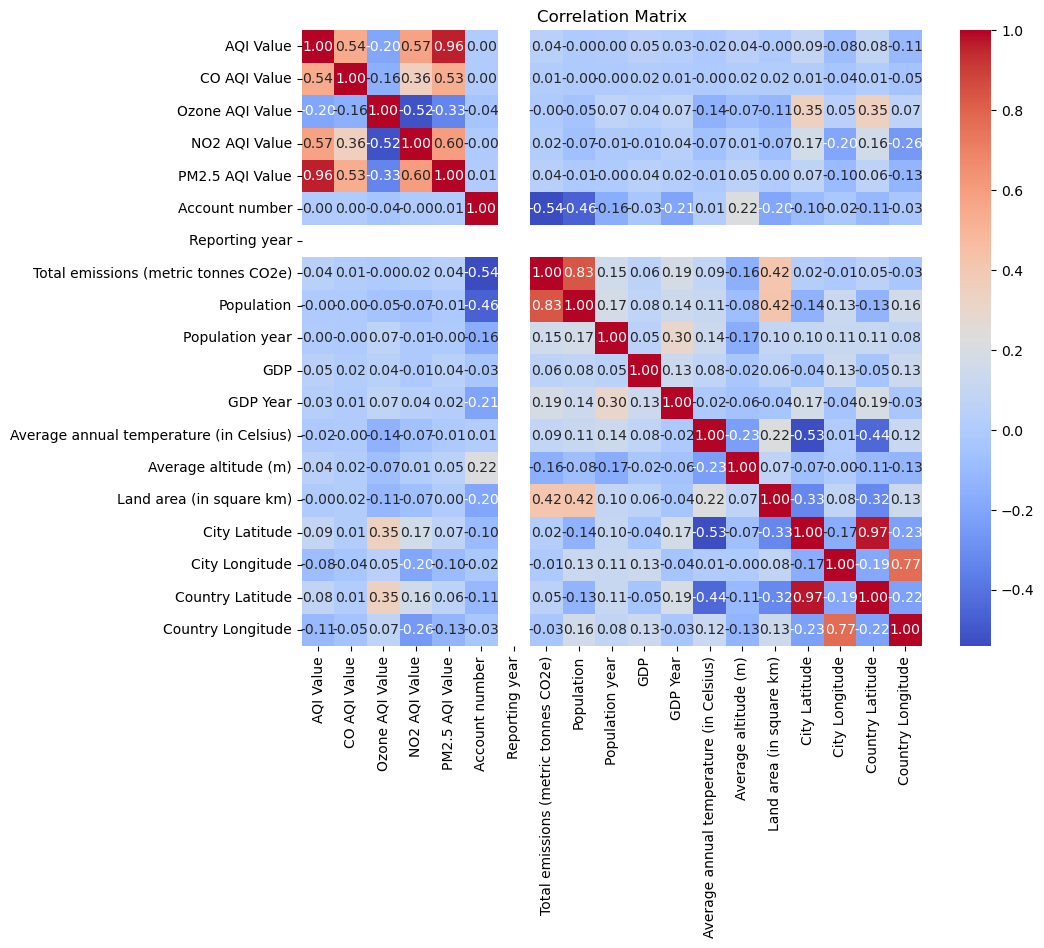

In [55]:
# We have to convert the data from float to int in order to use pandas to calculate the correlations
numeric_df = df.select_dtypes(include=['float64', 'int64'])


df_cleaned = numeric_df.dropna()
# Calculate the correlation matrix
corr_matrix = df_cleaned.corr()

# Plot the correlation matrix
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix')
plt.show()

In [ ]:
# Visualizing relationships between all numerical features
sns.pairplot(df.select_dtypes(include=['float64', 'int64']))
plt.show()


In [ ]:
plt.xlabel('AQI Value')
plt.ylabel('PM2.5 AQI Value')
plt.scatter(df['AQI Value'], df['PM2.5 AQI Value'], color='green')
plt.show()

In [ ]:
sns.distplot(df['AQI Value'],  label='AQI Value', norm_hist=True)  

In [ ]:
sns.distplot(df['PM2.5 AQI Value'],  label='PM2.5 AQI Value', norm_hist=True) 

In [ ]:
# Grouping the data by 'Country' and calculating the mean 'AQI Value' for each country
country_aqi_means = df.groupby('Country')['AQI Value'].mean()

# Sorting the countries by AQI value for better visualization
country_aqi_means = country_aqi_means.sort_values()

# Creating the bar chart
plt.figure(figsize=(15, 25)) 
plt.barh(country_aqi_means.index, country_aqi_means.values, color='skyblue') # Horizontal bar chart
plt.xlabel('Average AQI Value')
plt.ylabel('Country')
plt.title('Average AQI Value by Country')
plt.tight_layout() # Adjusts subplot params so that the subplot(s) fits in to the figure area.

plt.show()

In [ ]:
# Grouping the data by 'Country' and calculating the mean 'PM2.5 AQI Value' for each country
country_pm25_means = df.groupby('Country')['PM2.5 AQI Value'].mean()
# Sorting the countries by PM2.5 AQI value for better visualization
country_pm25_means = country_pm25_means.sort_values()
# Creating the bar chart
plt.figure(figsize=(15, 25))
plt.barh(country_pm25_means.index, country_pm25_means.values, color='skyblue') # Horizontal bar chart
plt.xlabel('Average PM2.5 AQI Value')
plt.ylabel('Country')
plt.title('Average PM2.5 AQI Value by Country')
plt.tight_layout() # Adjusts subplot params so that the subplot(s) fits in to the figure area.
plt.show()


In [ ]:
X = df['AQI Value'].values.reshape(-1, 1)
y = df['PM2.5 AQI Value'].values.reshape(-1, 1)

In [ ]:
# plot all
plt.ylabel('PM2.5 AQI Value')
plt.xlabel('AQI Value')
plt.scatter(X, y, color='blue')
plt.show()

In [ ]:
# X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1)
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=123, test_size=0.15) 

In [ ]:
# the shape of the subsets
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

In [ ]:
# creating an instance of Linear Regression model
myreg = LinearRegression()

In [ ]:
# fit it to our data
myreg.fit(X_train, y_train)
myreg

In [ ]:
# get the calculated coefficients
a = myreg.coef_
b = myreg.intercept_

In [ ]:
a

In [ ]:
b

In [ ]:
y_predicted = myreg.predict(X_test)
y_predicted

In [ ]:
y_test

In [ ]:
# Visualise the Linear Regression 
plt.title('Linear Regression')
plt.scatter(X, y, color='green')
plt.plot(X_train, a*X_train + b, color='blue')
plt.plot(X_test, y_predicted, color='orange')
plt.xlabel('length')
plt.ylabel('age')
plt.show()


In [ ]:
from sklearn.metrics import mean_squared_error, r2_score

# Predicting on the test set
y_pred = myreg.predict(X_test)

# Calculating metrics
print("R^2: ", r2_score(y_test, y_pred))
print("RMSE: ", np.sqrt(mean_squared_error(y_test, y_pred)))

In [ ]:
#create a scatter plot of the 'AQI Value' and 'PM2.5 AQI Value' columns and color the points by the 'Country' column
fig = px.scatter(df, x='AQI Value', y='PM2.5 AQI Value', color='Country', title='AQI Value vs PM2.5 AQI Value')
fig.show()


In [ ]:
# divide the data into 5 clusters using the KMeans algorithm
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=5)
kmeans.fit(df[['AQI Value', 'PM2.5 AQI Value']])
df['cluster'] = kmeans.predict(df[['AQI Value', 'PM2.5 AQI Value']])
df.sample(10)



In [ ]:
# create a scatter plot of the 'AQI Value' and 'PM2.5 AQI Value' columns and color the points by the 'cluster' column
fig = px.scatter(df, x='AQI Value', y='PM2.5 AQI Value', color='cluster', title='AQI Value vs PM2.5 AQI Value')
fig.show()


In [ ]:
# Fit the model and predict clusters
kmeans = KMeans(n_clusters=5, random_state=42).fit(df_filtered[['AQI Value', 'PM2.5 AQI Value']])
df_filtered['cluster'] = kmeans.labels_

# Analyze centroids
centroids = kmeans.cluster_centers_
print("Centroids:\n", centroids)

# Plotting clusters and centroids
plt.figure(figsize=(10, 6))
sns.scatterplot(data=df_filtered, x='AQI Value', y='PM2.5 AQI Value', hue='cluster', palette='viridis')
plt.scatter(centroids[:, 0], centroids[:, 1], s=100, c='red', label='Centroids')
plt.legend()
plt.show()


In [ ]:
population_data = df[['Country', 'Population']]

# Grouping and aggregating population data by country
population_by_country = population_data.groupby('Country')['Population'].sum().reset_index()

# Creating a pivot table with 'Country' as index
pivot_population = population_by_country.set_index('Country')

# Creating the heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(data=pivot_population, cmap='YlGnBu', annot=True, fmt=',.0f', linewidths=.5)
plt.title('Population by Country')
plt.xlabel('population')
plt.ylabel('Country')
plt.show()

In [ ]:
# Splitting the 'Country Location' column into separate longitude and latitude columns
df[['Latitude', 'Longitude']] = df['Country Location'].str.strip('()').str.split(', ', expand=True).astype(float)

# Creating a 3D scatter plot
scatter_plot = go.Scatter3d(
    x=df['Longitude'],
    y=df['Latitude'],
    z=df['Population year'],
    mode='markers',
    marker=dict(
        size=5,
        color='blue',                # Set color to an array/list of desired values
        opacity=0.8
    )
)

# Setting layout
layout = go.Layout(
    title='3D Population Map',
    scene=dict(
        xaxis=dict(title='Country Longitude'),
        yaxis=dict(title='Country Latitude'),
        zaxis=dict(title='Population')
    )
)

# Combining data and layout into a figure
fig = go.Figure(data=[scatter_plot], layout=layout)

# Show the figure
fig.show()

In [ ]:
df.sample()

In [ ]:
filtered_df = df[df['Country'] == 'Russian Federation']

In [ ]:
filtered_df.sample()

In [ ]:
df_europe = df[df['Continent'] == 'Europe']

In [ ]:
df_europe.sample(50)

In [ ]:
df_sampled = df_europe.sample(n=500, replace=False, random_state=42) 

In [ ]:
df_sampled.count()

In [ ]:
import folium
import json

# Load the GeoJSON data from a local file
with open(r"C:\Users\chz\Documents\BI Exercise\Datasæt\Eumap.json", 'r', encoding='utf-8') as f:
    geojson_data = json.load(f)

# Assuming 'df' is your DataFrame and already correctly set up
m = folium.Map(location=[df_sampled['Country Latitude'].mean(), df_sampled['Country Longitude'].mean()], zoom_start=3)

# Add markers for each data point
for index, row in df.iterrows():
    folium.Marker([row['Country Latitude'], row['Country Longitude']], popup=row['Population']).add_to(m)

# Add polygon overlays for countries using the loaded GeoJSON data
folium.GeoJson(data=geojson_data).add_to(m)

# Save and display the map
m.save('map.html')


In [ ]:
m